This notebook documents experimentations in performing whitebalance from the raw objects. To run this notebook it should be placed in the root directory of this project.

Very loosely adapted from [this issue](https://github.com/letmaik/rawpy/issues/12) on rawpy's repo. The idea is to keep the raw object open in ram and first produce a preview version of the image by applying postprocessing with minimilist paramaters. Then pass that preview to the cnn to determine the color checker location and avg white values. Then apply postprocessing once more this time with archival settings including: orientation and white balance values derived from the perview version.

This notebook also documents new methods used to extract the average white balance values from the color checker.

In [1]:
import piexif
import lensfunpy
from lensfunpy import XMLFormatError
import rawpy
import cv2
import numpy as np

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 10, 15
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

try:
    db = lensfunpy.Database()
except XMLFormatError:
# if there is a format error, attempt to use locally bundled xmls
    db = lensfunpy.Database(paths=glob.glob('libs/lensfunpy-db/*.xml')) # For future use    

In [2]:
from libs.ccRead import ColorchipRead
colorchipDetect = ColorchipRead()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [3]:
def scale_images_with_info(im, largest_dim=1875):
    """
    Function that scales images proportionally, and returns both the original image size as a tuple of image
    dimensions, and the scaled down image.
    :param im: Image to be scaled down.
    :type im: cv2 Image
    :param largest_dim: The largest dimension to be scaled down to.
    :type largest_dim: int
    :return: Returns both the original image dimensions as a tuple and the scaled image.
    :rtype: tuple, cv2 Image
    """
    image_height, image_width = im.shape[0:2]

    if image_width > image_height:
        reduced_im = cv2.resize(im, (largest_dim, round((largest_dim / image_width) * image_height)),
                                interpolation=cv2.INTER_AREA)
    else:
        reduced_im = cv2.resize(im, (round((largest_dim / image_height) * image_width), largest_dim),
                                interpolation=cv2.INTER_AREA)
    return (image_width, image_height), reduced_im


In [4]:
#imgPath = './exampleImages/various_images/Lisboa-201310659.NEF'
imgPath = './exampleImages/MOBOT_test_set/MO-3130581.CR2'

# Begin testing space

### baseline results, using nearly default rawpy values. This is only here to have something to compare the results to.

True

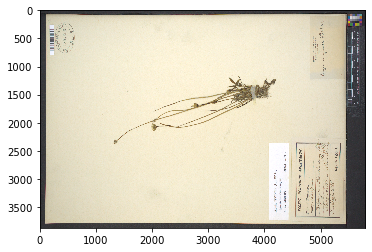

In [5]:
demosaic = rawpy.DemosaicAlgorithm.AHD
with rawpy.imread(imgPath) as raw:
    wb = raw.camera_whitebalance
    def_im = raw.postprocess(
        chromatic_aberration=(1, 1),
        user_wb=wb,
        demosaic_algorithm=demosaic
        )
    
imshow(def_im)
cv2.imwrite('def_img.png',cv2.cvtColor(def_im, cv2.COLOR_BGR2RGB))

### Load in a preview version which is essentially unprocessed. Use it to derive params for proper postprocessing

Note: The half green values necessary to keep the entire image being washed in green. No idea why that is the case!

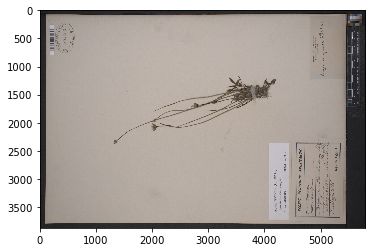

In [28]:
demosaic = rawpy.DemosaicAlgorithm.AHD
raw_base = rawpy.imread(imgPath)

unedited_raw = raw_base.postprocess(output_color=rawpy.ColorSpace.raw,
                                    half_size=True,
                                    use_auto_wb=False,
                                    user_wb=[1, 0.5, 1, 0],
                                    no_auto_bright=True,
                                    demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR
                                   )

cv2.imwrite('unprocessed_img.png',cv2.cvtColor(unedited_raw, cv2.COLOR_BGR2RGB))
imshow(unedited_raw)
raw_base.close()

### Extract color chip from the unedited_raw

[array([[112,  38],
       [110,  74],
       [ 59,  74],
       [ 60,  37]], dtype=int32), array([[112,  36],
       [109,  75],
       [ 59,  75],
       [ 60,  35]], dtype=int32), array([[124,  22],
       [ 47,  24],
       [ 45,  88],
       [124,  88]], dtype=int32), array([[  0,  21],
       [  0, 124],
       [ 37, 124],
       [ 38,  23]], dtype=int32), array([[ 35,  22],
       [  0,  22],
       [  0, 124],
       [ 36, 124]], dtype=int32)]
High precision took 0.006345033645629883 seconds.
Color chip cropping took: 1.1520497798919678 seconds.
(5471.424, 68.00319488817891, 5857.824, 454.3849840255591)


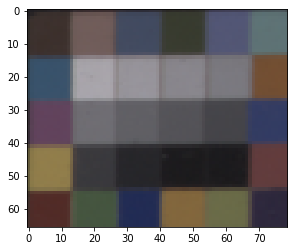

In [29]:
original_size, reduced_img = scale_images_with_info(unedited_raw)
cc_position, cropped_cc, cc_crop_time = colorchipDetect.process_colorchip_small(reduced_img,
                                                                                original_size,
                                                                                stride_style='quick',
                                                                                high_precision=True)
imshow(cropped_cc)
print(cc_position)

Note: initial load in does not look proper without half g values

end


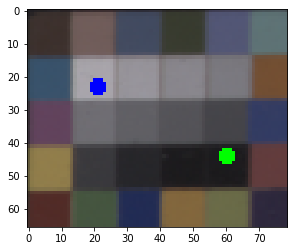

In [30]:
# Test code exploring minmax

image = cropped_cc.copy()
radius = 1

### Convert to grayscale
grayImg = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  #convert to gray
### Find the darkest and brightest region
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(grayImg)
### Draw circles around the darkesst and brightest region
cv2.circle(image, maxLoc, radius, (0, 0, 255), 2)       #draw a circle around the bright area
cv2.circle(image, minLoc, radius, (0, 255, 0), 2) 
imshow(image)

damn... look at those points! Slick stuff.

Mask the whitest value using floodfill masking

In [31]:
def extract_white_vals(cropped_cc):
    grayImg = cv2.cvtColor(cropped_cc, cv2.COLOR_RGB2GRAY) #convert to gray
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(grayImg)
    # determine an allowable range for the floodfill
    var_threshold = int((maxVal-minVal) * .1)
    h,w,chn = cropped_cc.shape
    seed = maxLoc
    mask = np.zeros((h+2,w+2),np.uint8)
    floodflags = 8
    floodflags |= cv2.FLOODFILL_FIXED_RANGE
    floodflags |= cv2.FLOODFILL_MASK_ONLY
    floodflags |= (int(maxVal) << 8)
    num,cropped_cc,mask,rect = cv2.floodFill(cropped_cc, mask, seed,
                                             0,
                                             (var_threshold,)*3,
                                             (var_threshold,)*3,
                                             floodflags)
    # correct for the mask expansion
    mask = mask[1:-1, 1:-1, ...]
    # extract the rgb values of the floodfilled sections
    extracted = cropped_cc[ mask != 0]
    # get mean of the resulting r,g,b values
    avg_white = extracted.reshape(-1,extracted.shape[-1]).mean(0)
    # convert it to an array of ints
    avg_white = np.asarray(avg_white, dtype=int)
    return list(avg_white)

# only slightly modified for the black values although so far we have not found black values necessary.

def extract_black_vals(cropped_cc):
    grayImg = cv2.cvtColor(cropped_cc, cv2.COLOR_RGB2GRAY) #convert to gray
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(grayImg[...,1])
    # determine an allowable range for the floodfill
    var_threshold = int((maxVal-minVal) * .1)
    h,w,chn = cropped_cc.shape
    seed = minLoc
    mask = np.zeros((h+2,w+2),np.uint8)
    floodflags = 8
    floodflags |= cv2.FLOODFILL_FIXED_RANGE
    floodflags |= cv2.FLOODFILL_MASK_ONLY
    floodflags |= (int(minVal) >> 8)
    num,cropped_cc,mask,rect = cv2.floodFill(cropped_cc, mask, seed,
                                             0,
                                             (var_threshold,)*3,
                                             (var_threshold,)*3,
                                             floodflags)
    # correct for the mask expansion
    mask = mask[1:-1, 1:-1, ...]
    # extract the rgb values of the floodfilled sections
    extracted = cropped_cc[ mask != 0]
    # get mean of the resulting r,g,b values
    avg_black = extracted.reshape(-1,extracted.shape[-1]).mean(0)
    # convert it to an array of ints
    avg_black = np.asarray(avg_black, dtype=int)

    return list(avg_black)

In [32]:
cc_avg_white = extract_white_vals(cropped_cc)
cc_avg_white

[166, 163, 169]

In [33]:
# exploring dir of raw classes

# raw_base = rawpy.imread(imgPath)
# print(dir(raw_base))
# # I can retrieve the color order in the raw
# # desc = raw_base.color_desc.decode('utf8')
# # pattern = raw_base.raw_pattern
# # color_lookup = {k:v for k, v in enumerate(desc)}
# # c_pattern = np.vectorize(color_lookup.get)(pattern)
# # c_pattern.flatten()
# # translated as c_pattern, for CR2 it is RGGB
# # print(c_pattern)

# # print(raw_base.daylight_whitebalance)
# # print(raw_base.camera_whitebalance)
# # print(raw_base.black_level_per_channel)
# # print(raw_base.raw_type)
# # print(raw_base.rgb_xyz_matrix)

# print(raw_base.black_level_per_channel)
# raw_base.postprocess()

# # 2830, 107
# # 214, 5660

# raw_base.close()

using coords for white point:
  -  xyz = raw_base.raw_value_visible(130,5530)  was 4760
using coords for black point:
  -  xyz = raw_base.raw_value_visible(214, 5660) was 2205

Notes on wb from:
https://www.libraw.org/node/2411
some camera records four multipliers, while some (RGB/3 color) may use only three. In the second case, the cam_mul[1] (Green) should be copied to cam_mul[3] ('second green')

After that, cam_mul[] is usually normalized (i.e. divided to smallest value, so [1500,1000,1200,1000] will become [1.5,1,1.2,1])

And, yes, then color channels are multiplied to cam_mul[color] values.


### Now postprocess a high quality version and close up the raw_base

1.1523593739680835
 calc avg white:  [1.536144578313253, 1.5644171779141105, 1.5088757396449703]
 raw daylight wb: [2.1251654624938965, 0.9439765214920044, 1.338605284690857, 0.0]
 raw camera wb:   [1949.0, 1024.0, 1975.0, 1024.0]
 calculated wb:   [1.536144578313253, 0.7822085889570553, 1.5088757396449703, 0.7822085889570553]


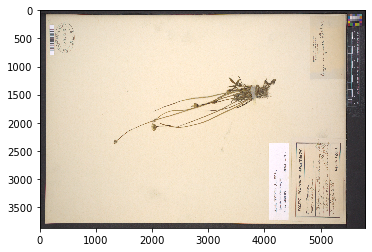

In [118]:
raw_base = rawpy.imread(imgPath)
cc_avg_white = extract_white_vals(cropped_cc)
# normalize each value by 255
cc_avg_white = [255/x for x in cc_avg_white]
r,g,b = cc_avg_white
g = g/2
wb = [r, g, b, g]
rgb_cor = raw_base.postprocess(demosaic_algorithm=rawpy.DemosaicAlgorithm.AHD,
                                          dcb_enhance = True,
                                          use_camera_wb=False,
                                          use_auto_wb=False,
                                          user_wb=wb,
                                          output_color=rawpy.ColorSpace.sRGB,
                                          output_bps=8,
                                          user_flip=None,
                                          user_sat=None,
                                          auto_bright_thr=None,
                                          bright=1.0,
                                          exp_shift=None,
                                          chromatic_aberration= (1,1),
                                          exp_preserve_highlights=1.0,
                                          no_auto_scale=False,
                                          gamma=None
                                         )

cv2.imwrite('1_rgb_cor.png', cv2.cvtColor(rgb_cor, cv2.COLOR_BGR2RGB))
imshow(rgb_cor)
raw_base.close()

### Test new vs old white value extraction methods
"old" method is ld_chip_whitevals. Present before commit:

https://github.com/CapPow/autoPostProcessing/commit/be94876243ba7aa609f66bab94d9ccfe49b8f9a4



In [ ]:
def old_chip_whitevals(color_chip_image):
    """
    Takes the white values within the cropped CC image and averages them in RGB. The whitest values in the image is
    determined in the L*a*b color space, wherein only lightness values higher than (max lightness value - 1) is
    considered

    :param color_chip_image: The cropped color chip image.
    :type color_chip_image: Image
    :return: Returns a list of the averaged whitest values
    :rtype: list
    """
    cci_array = np.array(color_chip_image,  dtype=np.uint8)
    ccil_array = cv2.cvtColor(color_chip_image, cv2.COLOR_RGB2Lab)
    width, height = ccil_array.shape[0], ccil_array.shape[1]
    # id max_lightness in ccil (lab space)
    max_lightness = ccil_array[...,0].max()
    # index cci_array based on conditions met in ccil_array
    white_pixels_rgbvals = cci_array[ ccil_array[...,0]> max_lightness-1]
    white_pixels_average = np.average(white_pixels_rgbvals, axis=0)

    return list(white_pixels_average)


In [ ]:
orig_times = []
orig_values = []
new_times = []
new_values = []

import time

for i in range(0, 10000):
    startTime = time.time()
    cc_avg_white = old_chip_whitevals(cropped_cc)
    orig_values.append(cc_avg_white)
    endTime = time.time() - startTime
    orig_times.append(endTime)
    ###
    #space between processes
    ###
    startTime = time.time()
    cc_avg_white = extract_white_vals(cropped_cc)
    new_values.append(cc_avg_white)
    endTime = time.time() - startTime
    new_times.append(endTime)

avg_old = np.mean(orig_times)
avg_old_vals = np.mean(orig_values)
print(avg_old)
print(avg_old_vals)
avg_new = np.mean(new_times)
avg_new_vals = np.mean(new_values)
print(avg_new)
print(avg_new_vals)

#### Conclusion
This is a silly exercise, the new method IS faster but... the times involved are absurdly small to start with. The average white value returned is slightly less bright
No one will notice the improvement.

Interestingly, the black values could be determined at the same time for around the same cpu time as the 'old' method.